# **Loan Application Outcome Predictor**

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("C:\Janhvi\Freshman Spring\mortgage.csv")
print(data.shape)

(136261, 38)


# Data Preprocessing

In [3]:
from sklearn.preprocessing import OrdinalEncoder
#ordinal encoding of applicant age
data['applicant_age'].unique()
age_sort = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74']
age_enc = OrdinalEncoder(categories=[age_sort])
data['applicant_age'] = age_enc.fit_transform(data['applicant_age'].values.reshape(-1,1))

In [4]:
data.dropna(subset=['debt_to_income_ratio','income'],inplace=True)
data['debt_to_income_ratio'].unique()
age_sort = ['<20%', '20%-<30%', '30%-<36%', '36%-<41%', '41%-<46%', '46%-<50%', '50%-60%','>60%']
debt_enc = OrdinalEncoder(categories=[age_sort])
data['debt_to_income_ratio'] = debt_enc.fit_transform(data['debt_to_income_ratio'].values.reshape(-1,1))

In [5]:
data['ethnicity'] = data['ethnicity'].replace({'Hispanic or Latino':1, 'Joint':0.5, 'Not Hispanic or Latino':0})
data['sex'] = data['sex'].replace({'Joint':0.5, 'Female':1, 'Male':0})

data.drop(data[data['race'] == "Free Form Text Only"].index, inplace=True)
data.drop(data[data['race'] == "Joint"].index, inplace=True)

dummies = pd.get_dummies(data['race'])
data = pd.concat([data,dummies], axis=1)
data.drop(labels=['race'], axis=1, inplace=True)

data.drop(data[data['ethnicity'] == "Free Form Text Only"].index, inplace=True)
data.drop(data[data['sex'] == "Free Form Text Only"].index, inplace=True)
print(data.shape)

(129226, 43)


In [6]:
def normalize(column,data):
    norm = data.copy()
    #data[feature] = data[feature]  / data[feature].abs().max()
    data[column] = (norm[column] - norm[column].min()) / (norm[column].max() - norm[column].min())
    return data

data = normalize('combined_loan_to_value_ratio', data)
data = normalize('loan_amount', data)
data = normalize('property_value', data)
data = normalize('income', data)

In [7]:
def one_hot(feature, data):
    for column in feature:
        dummies = pd.get_dummies(data[column])
        data = pd.concat([data,dummies], axis=1)
        data.drop(labels=[column], axis=1, inplace=True)
    return data

categorical = one_hot(['conforming_loan_limit','construction_method','loan_type','lien_status','occupancy_type'],data)
data = pd.concat([categorical,data],axis=1)
print(data.shape)

(129226, 94)


In [8]:
data.drop(labels=['total_loan_costs'], axis=1, inplace=True)
data.dropna(subset=['combined_loan_to_value_ratio', 'property_value'],inplace=True)

In [9]:
X_dem = data.iloc[:,5:11]
X_loan = data.iloc[:,21:29]
X_loan.head()
X_loan.drop(labels=['discount_points','interest_rate','lender_credits'], axis=1, inplace=True)
X = pd.concat([X_dem,X_loan],axis=1)

y = data.iloc[:,29]
print(X.shape)
X.head()

(124547, 11)


,applicant_age,applicant_age_above_62,ethnicity,sex,income,debt_to_income_ratio,business_or_commercial_purpose,combined_loan_to_value_ratio,loan_amount,property_value,total_units
0,3.0,0.0,1,0.0,0.000442,7.0,0.0,0.001005,0.010976,0.010653,1.0
1,4.0,0.0,0,0.5,0.000678,7.0,0.0,0.000689,0.392683,0.333807,1.0
2,3.0,0.0,1,0.5,0.000482,4.0,0.0,0.000584,0.012195,0.012784,1.0
3,4.0,1.0,1,1.0,0.000442,3.0,0.0,0.000176,0.007317,0.026278,1.0
4,5.0,1.0,0,0.0,0.000447,1.0,0.0,0.000299,0.008537,0.016335,1.0


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# K-Best Features with Logistic Regression

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model = SelectKBest(chi2, k=5)
X_new = model.fit_transform(X_train, y_train)

In [34]:
mask = model.get_support()
new_features = X.columns[mask]
print(new_features)

Index(['applicant_age', 'applicant_age_above_62', 'ethnicity',
       'debt_to_income_ratio', 'business_or_commercial_purpose'],
      dtype='object')


In [35]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=1, max_iter=1000)
logreg.fit(X_new, y_train)

LogisticRegression(max_iter=1000, random_state=1)

In [36]:
print(logreg.score(X_test[new_features], y_test))

0.8924528301886793


# Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier

#feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0, class_weight="balanced_subsample")
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=0)

In [46]:
y_pred = forest.predict(X_test)
print(forest.score(X_test,y_test))

0.9113608992372542


In [47]:
importance = forest.feature_importances_
descending = np.argsort(importance)

variables = X.columns[:] 

# Visualization

In [18]:
import matplotlib
from matplotlib import pyplot as plt
from sklearn import tree

<AxesSubplot:xlabel='Importance', ylabel='Features'>

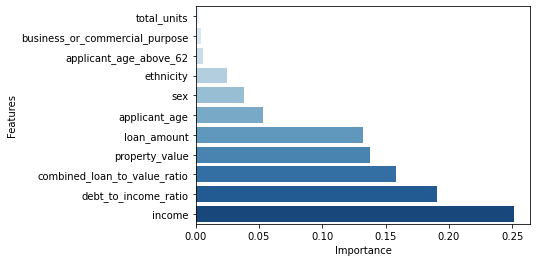

In [19]:
import seaborn as sns

df = pd.DataFrame({"Features":variables[descending], "Importance":importance[descending]})
sns.set_color_codes("muted")
sns.barplot(x="Importance", y="Features", data=df, palette="Blues")

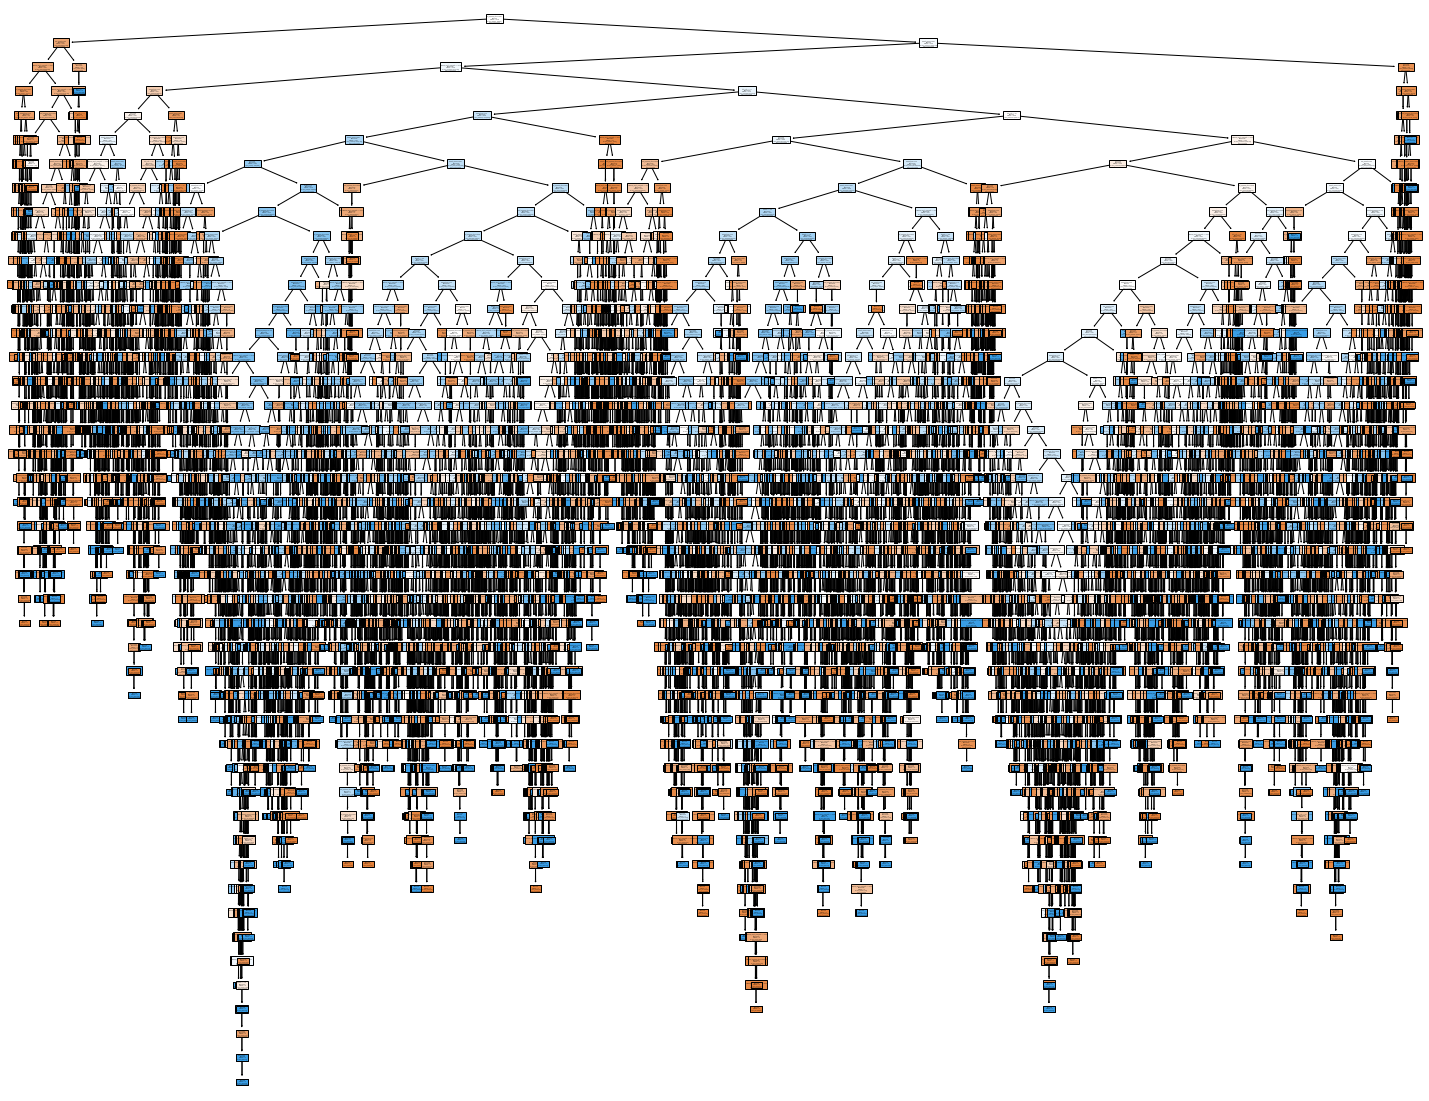

In [20]:
estimator = forest.estimators_

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(estimator[0], 
                   feature_names=variables[descending],
                   class_names=["rejected", "accepted"],
                   filled=True)


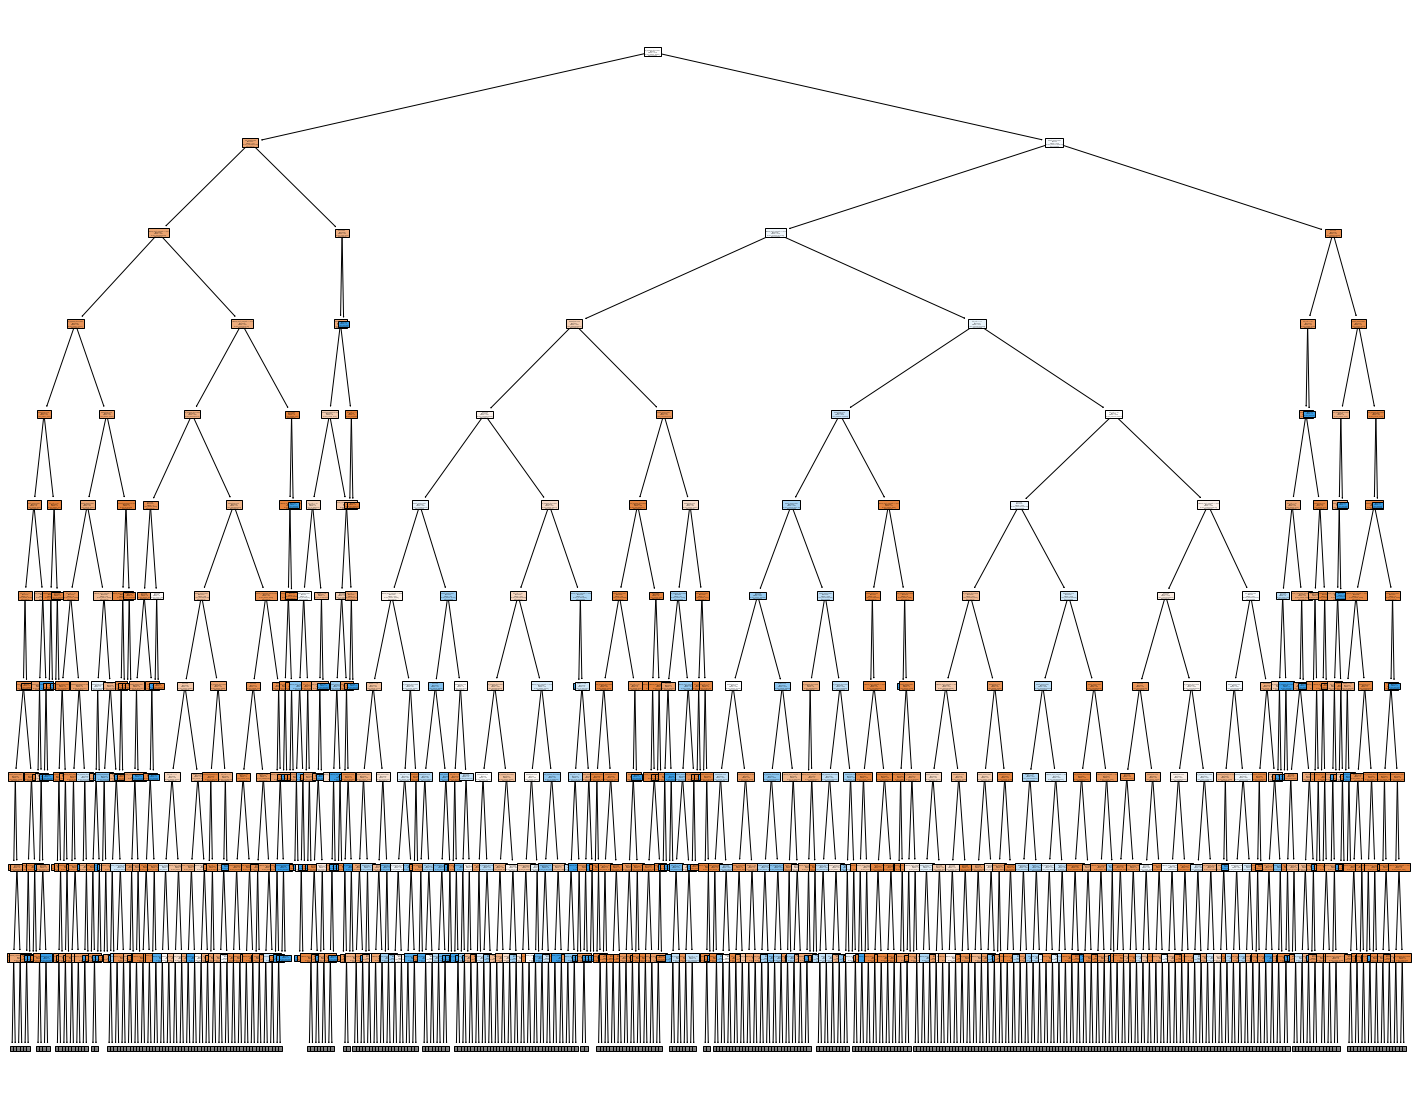

In [22]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(estimator[0], max_depth=10, 
                   feature_names=variables[descending],
                   class_names=["rejected", "accepted"],
                   filled=True)

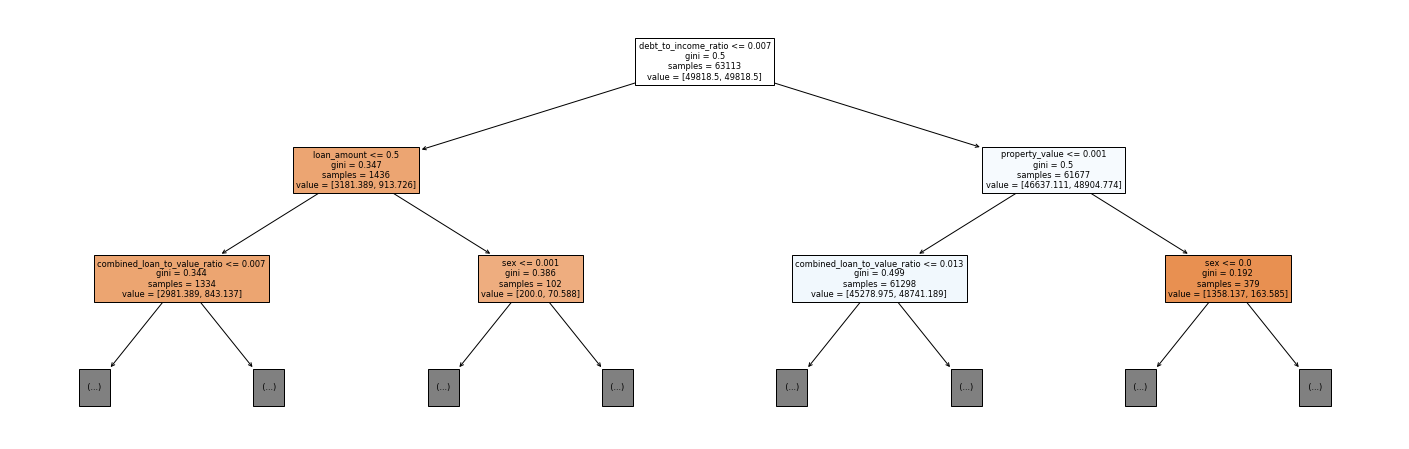

In [45]:
fig = plt.figure(figsize=(25,8))
_ = tree.plot_tree(estimator[0], max_depth=2, 
                   feature_names=variables[descending],
                   filled=True)

In [44]:
print("Total Number of Estimators: ", len(estimator))

Total Number of Estimators:  100


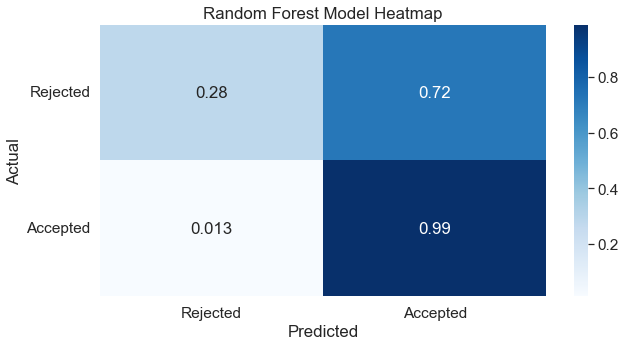

In [66]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,5))
sns.heatmap(mat, annot=True, cmap=plt.cm.Blues)

categories = ['Rejected','Accepted']
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Model Heatmap')
ticks = np.arange(len(categories))
plt.xticks(ticks + .5, categories)
plt.yticks(ticks + .5, categories, rotation=0)
plt.show()